## Anchor Direction Visualization Framework: DeepSurv trained on the Rotterdam dataset (where the encoder has a Euclidean norm 1 constraint); anchor direction estimation and visualization use the GBSG dataset

This notebook is nearly the same as the one for SUPPORT.

### Loading in data (including some outputs from the already trained neural survival analysis model)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = ['sans-serif', 'Arial']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import scipy.stats

from visualization_utils import get_experiment_data, l2_normalize_rows, longest_common_prefix, \
    compute_median_survival_times

In [2]:
emb_direction, emb_vis, raw_direction, raw_vis, label_direction, label_vis, \
    _, unique_train_times, predicted_surv_vis \
        = get_experiment_data('rotterdam-gbsg', '../train_models/output_tabular_hypersphere')

In [3]:
emb_direction.shape

(171, 5)

### 2D PCA plot of the visualization data

In [4]:
median_surv_time_estimates = compute_median_survival_times(predicted_surv_vis, unique_train_times)

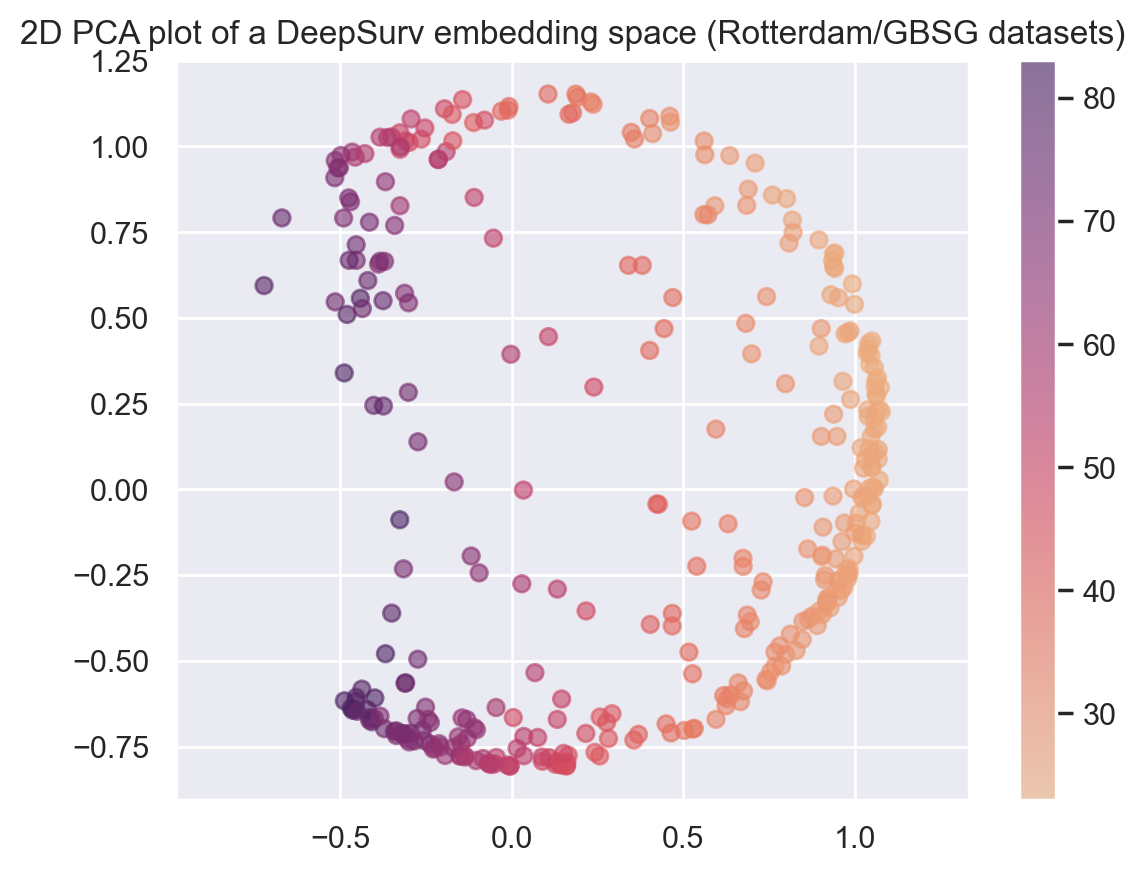

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_vis_pca_2d = pca.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_pca_2d[:, 0], emb_vis_pca_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D PCA plot of a DeepSurv embedding space (Rotterdam/GBSG datasets)')
plt.savefig('rotterdam-gbsg-embedding-space-pca-hypersphere.pdf', bbox_inches='tight')

### 2D t-SNE plot of the visualization data

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


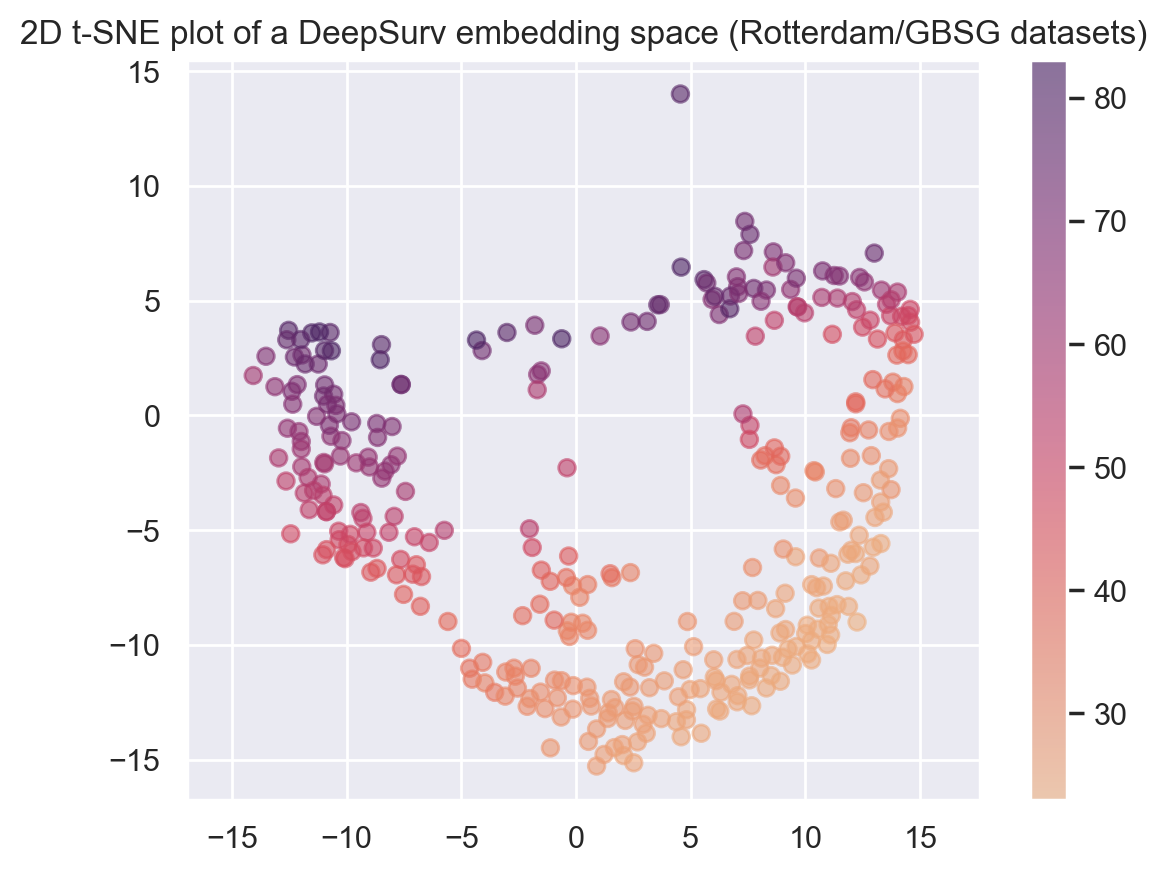

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=3676767249)
emb_vis_tsne_2d = tsne.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_tsne_2d[:, 0], emb_vis_tsne_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D t-SNE plot of a DeepSurv embedding space (Rotterdam/GBSG datasets)')
plt.savefig('rotterdam-gbsg-embedding-space-tsne-hypersphere.pdf', bbox_inches='tight')

### For different choices for the number of components, fit a mixture of von Mises-Fisher distributions

We use the Expectation-Maximization algorithm implementation by Minyoung Kim: https://github.com/minyoungkim21/vmf-lib

In [7]:
from lifelines.statistics import pairwise_logrank_test
import random
import torch

import models
import utils

seed = 1861600023

n_init = 100
n_clusters_to_try = list(range(2, 11))
logrank_p_values = []
cluster_assignments = []
cluster_models = []
samples = torch.tensor(emb_direction, dtype=torch.float32)
opts = {}
opts['max_iters'] = 100  # maximum number of EM iterations
opts['rll_tol'] = 1e-5  # tolerance of relative loglik improvement
for n_clusters in n_clusters_to_try:
    print('Trying %d clusters...' % n_clusters)

    best_ll = -np.inf
    best_cluster_assignment = None
    for repeat_idx in range(n_init):
        random.seed(seed + repeat_idx)
        np.random.seed(seed + repeat_idx)
        torch.manual_seed(seed + repeat_idx)
        torch.cuda.manual_seed(seed + repeat_idx)
        torch.cuda.manual_seed_all(seed + repeat_idx)

        # create a model
        mix = models.MixvMF(x_dim=emb_direction.shape[1], order=n_clusters)

        # EM learning
        ll_old = -np.inf
        with torch.no_grad():

            for steps in range(opts['max_iters']):

                # E-step
                logalpha, mus, kappas = mix.get_params()
                logliks, logpcs = mix(samples)
                ll = logliks.sum()
                jll = logalpha.unsqueeze(0) + logpcs
                qz = jll.log_softmax(1).exp()

                # tolerance check
                if steps > 0:
                    rll = (ll-ll_old).abs() / (ll_old.abs()+utils.realmin)
                    if rll < opts['rll_tol']:
                        break

                ll_old = ll

                # M-step
                qzx = ( qz.unsqueeze(2) * samples.unsqueeze(1) ).sum(0)
                qzx_norms = utils.norm(qzx, dim=1)
                mus_new = qzx / qzx_norms
                Rs = qzx_norms[:,0] / (qz.sum(0) + utils.realmin)
                kappas_new = (mix.x_dim*Rs - Rs**3) / (1 - Rs**2 + 1e-6)
                alpha_new = qz.sum(0) / samples.shape[0]

                # assign new params
                mix.set_params(alpha_new, mus_new, kappas_new)

            logliks, logpcs = mix(samples)
            ll = logliks.sum()
            if ll > best_ll:
                best_ll = ll
                best_cluster_assignment = np.argmax(logpcs.numpy(), axis=1)

    result = pairwise_logrank_test(label_direction[:, 0],
                                   best_cluster_assignment,
                                   label_direction[:, 1])
    logrank_p_values.append(result.p_value)
    cluster_assignments.append(best_cluster_assignment)

Trying 2 clusters...
Trying 3 clusters...
Trying 4 clusters...
Trying 5 clusters...
Trying 6 clusters...
Trying 7 clusters...
Trying 8 clusters...
Trying 9 clusters...
Trying 10 clusters...


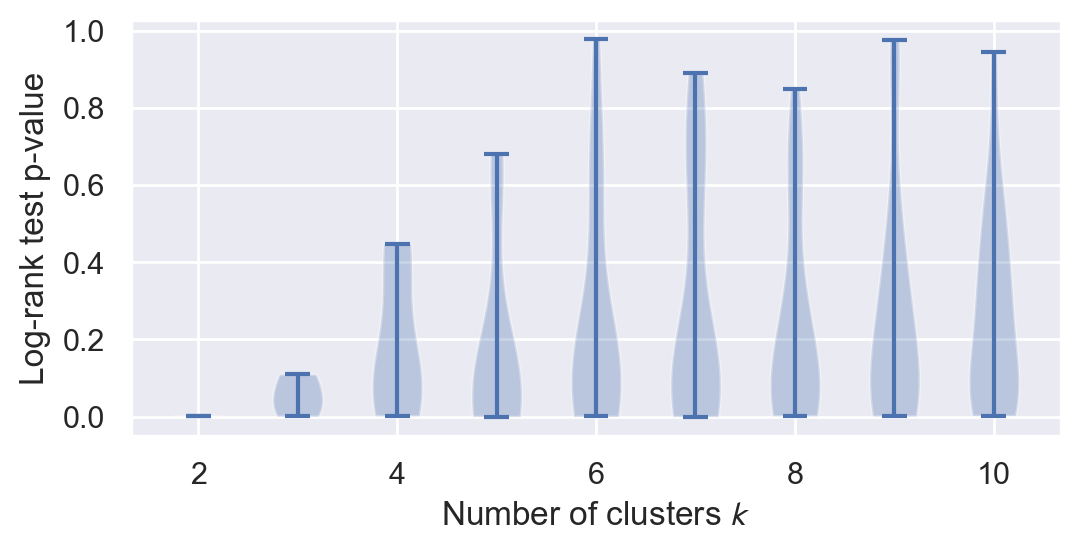

In [8]:
plt.figure(figsize=(6, 2.7))
plt.violinplot(logrank_p_values, n_clusters_to_try)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Log-rank test p-value')
plt.savefig('rotterdam-gbsg-logrank-pvalue-vs-nclusters-hypersphere.pdf', bbox_inches='tight')

### Using different clusters' anchor directions, make various visualizations

In [9]:
final_n_clusters = 3

In [10]:
final_cluster_assignment = cluster_assignments[n_clusters_to_try.index(final_n_clusters)]

/home/george/anaconda3_UDA/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Raw count')

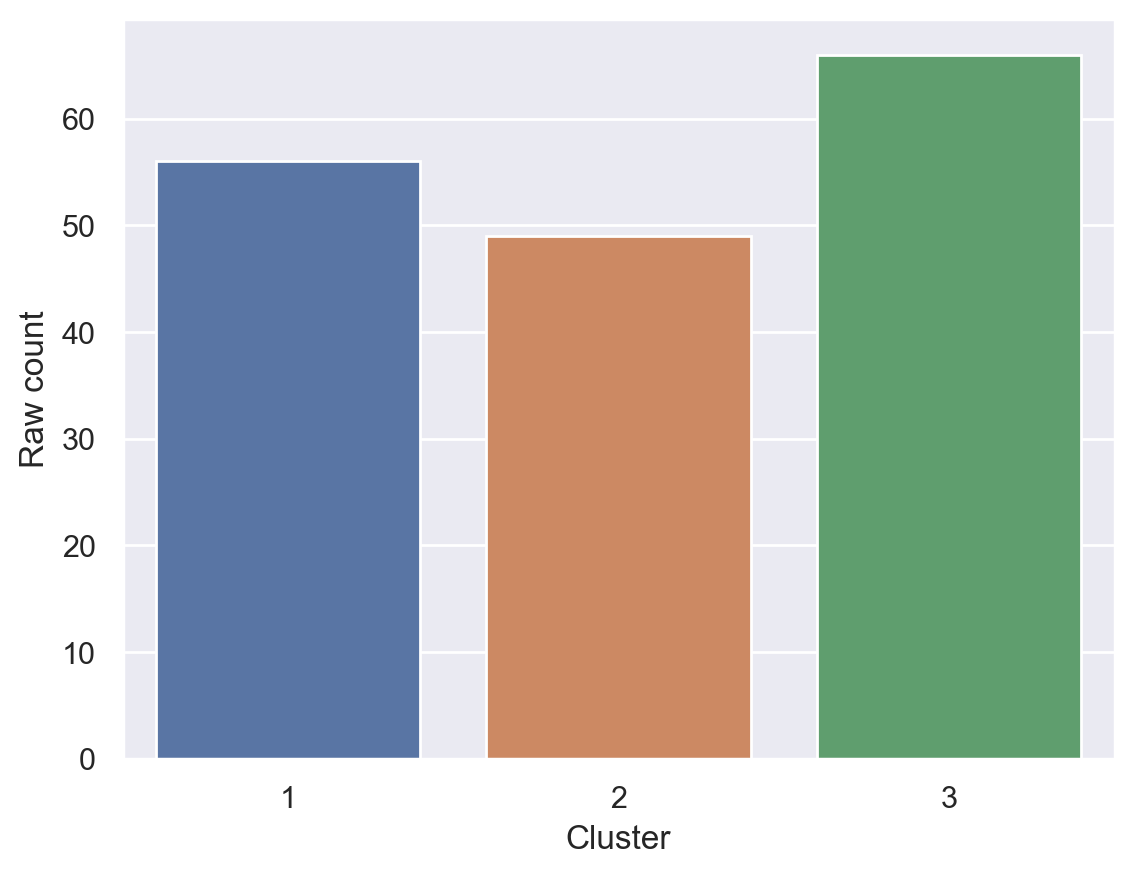

In [11]:
from collections import Counter
histogram = Counter(final_cluster_assignment)
sns.barplot(np.arange(final_n_clusters) + 1,
            [histogram[cluster_idx] for cluster_idx in range(final_n_clusters)])
plt.xlabel('Cluster')
plt.ylabel('Raw count')

In [12]:
center_of_mass = emb_direction.mean(axis=0)

In [13]:
anchor_directions = np.array([emb_direction[final_cluster_assignment == cluster_idx].mean(axis=0) - center_of_mass
                              for cluster_idx in range(final_n_clusters)])

In [14]:
# code that discretizes the all raw features (discrete and continuous) for raw feature probability heatmap
# visualizations (this code is specific to the Rotterdam/GBSG datasets but can be modified for other tabular data)

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

def transform(raw_features, continuous_n_bins=5):
    feature_names = ['hormonal therapy',
                     'tumor size',
                     'postmenopausal',
                     'age',
                     'number of positive nodes',
                     'progesterone receptor',
                     'estrogen receptor']
    leave_indices = [0, 2]
    continuous_indices = [1, 3, 4, 5, 6]
    discretized_features = []
    discretized_feature_names = []
    all_n_bins_to_use = []
    for idx in continuous_indices:
        n_bins_to_use = continuous_n_bins
        discretizer = KBinsDiscretizer(n_bins=n_bins_to_use,
                                       strategy='quantile',
                                       encode='onehot-dense')
        new_features = discretizer.fit_transform(raw_features[:, idx].reshape(-1, 1).astype(float))
        if discretizer.n_bins_[0] != n_bins_to_use:
            n_bins_to_use = discretizer.n_bins_[0]

        if n_bins_to_use > 1:
            discretized_features.append(new_features)
            for bin_idx in range(n_bins_to_use):
                if bin_idx == 0:
                    discretized_feature_names.append(feature_names[idx] + ' bin#1(-inf,%.2f)' % discretizer.bin_edges_[0][bin_idx+1])
                elif bin_idx == n_bins_to_use - 1:
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,inf)' % (n_bins_to_use, discretizer.bin_edges_[0][bin_idx]))
                else:
                    # print(discretizer.bin_edges_[0][bin_idx:bin_idx+2])
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,%.2f)' % tuple([bin_idx + 1] + list(discretizer.bin_edges_[0][bin_idx:bin_idx+2])))
        all_n_bins_to_use.append(n_bins_to_use)
    for idx in leave_indices:
        discretized_features.append(raw_features[:, idx].reshape(-1, 1).astype(float))
        discretized_feature_names.append(feature_names[idx])
        all_n_bins_to_use.append(1)
    return np.hstack(discretized_features), discretized_feature_names, all_n_bins_to_use

In [15]:
raw_vis_discretized, discretized_feature_names, all_n_bins_to_use = transform(raw_vis)

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


For each cluster, rank raw features using p-values from the chi-squared test of independence (raw feature vs projection value along the current cluster's anchor direction):

In [16]:
all_raw_feature_probability_heatmaps = []
all_bin_edges = []

n_bins = 7
emb_vis_normalized = l2_normalize_rows(emb_vis - center_of_mass[np.newaxis, :])
anchor_directions_normalized = l2_normalize_rows(anchor_directions)
for cluster_idx in range(final_n_clusters):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

    bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
    bin_edges_copy_with_inf_right_edge = bin_edges.copy()
    bin_edges_copy_with_inf_right_edge[-1] = np.inf

    bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

    heatmap = np.zeros((len(discretized_feature_names), n_bins))
    for discretized_feature_idx in range(len(discretized_feature_names)):
        for projection_bin_idx in range(n_bins):
            heatmap[discretized_feature_idx, projection_bin_idx] = raw_vis_discretized[bin_assignments == projection_bin_idx][:, discretized_feature_idx].mean()

    all_raw_feature_probability_heatmaps.append(heatmap)
    all_bin_edges.append(bin_edges)

    # compute ranking table
    projection_bin_counts = np.array([(bin_assignments == bin_idx).sum() for bin_idx in range(n_bins)])
    print('[Cluster %d]' % (cluster_idx + 1))
    current_row = 0
    variable_pval_pairs = []
    for variable_idx in range(len(all_n_bins_to_use)):
        n_bins_to_use = all_n_bins_to_use[variable_idx]
        if n_bins_to_use >= 2:
            prefix = \
                longest_common_prefix([discretized_feature_names[idx]
                                       for idx in range(current_row,
                                                        current_row + n_bins_to_use)])
            if prefix.endswith('(') or prefix.endswith('['):
                prefix = prefix[:-1]
            if prefix.endswith(' cat#') or prefix.endswith(' bin#'):
                prefix = prefix[:-5]
            prefix = prefix.strip()
            res = scipy.stats.chi2_contingency(
                heatmap[current_row:(current_row + n_bins_to_use), :]
                * projection_bin_counts[np.newaxis, :])
            variable_pval_pairs.append((prefix, res[1]))
        else:
            indicator_row = heatmap[current_row:(current_row + n_bins_to_use), :]
            res = scipy.stats.chi2_contingency(
                np.array([[indicator_row, 1. - indicator_row]])
                * projection_bin_counts[np.newaxis, :])
            # print(discretized_feature_names[current_row], res[1])
            variable_pval_pairs.append((discretized_feature_names[current_row], res[1]))
        current_row += n_bins_to_use
    for idx, (variable_name, pval) in enumerate(sorted(variable_pval_pairs, key=lambda x: x[1])):
        print(idx + 1, '-', variable_name, '-', pval)
        #print('%d &' % (idx + 1), variable_name, (('& $%.2E' % pval).replace('E-', '\\times 10^{-') + '}$ \\\\').replace('^{-0', '^{-'))
    print()

[Cluster 1]
1 - age - 6.219718313915319e-50
2 - postmenopausal - 1.3570139037440053e-40
3 - number of positive nodes - 3.505279578609736e-27
4 - estrogen receptor - 2.6740701981797342e-14
5 - progesterone receptor - 1.993291086972232e-07
6 - tumor size - 4.114430524619924e-05
7 - hormonal therapy - 0.008387595711270372

[Cluster 2]
1 - number of positive nodes - 1.5821950064788016e-98
2 - hormonal therapy - 4.3160222018495747e-14
3 - tumor size - 2.5248666014412823e-09
4 - progesterone receptor - 6.659755038041053e-06
5 - age - 1.4660600217524164e-05
6 - estrogen receptor - 0.0005019953574997283
7 - postmenopausal - 0.06305758204326525

[Cluster 3]
1 - age - 1.0706339597139658e-35
2 - postmenopausal - 5.564872773185437e-33
3 - number of positive nodes - 2.6056079994925105e-30
4 - hormonal therapy - 2.4666756382077307e-10
5 - estrogen receptor - 0.002052288739775615
6 - tumor size - 0.26060795515167395
7 - progesterone receptor - 0.26210151494267464



These are the projection bin edges, just for reference:

In [17]:
for cluster_idx in range(final_n_clusters):
    print(cluster_idx + 1, all_bin_edges[cluster_idx])

1 [-0.99915913 -0.71478573 -0.43041232 -0.14603892  0.13833448  0.42270788
  0.70708128  0.99145469]
2 [-0.99805316 -0.71306906 -0.42808496 -0.14310086  0.14188324  0.42686734
  0.71185144  0.99683555]
3 [-0.99370711 -0.70922191 -0.4247367  -0.1402515   0.14423371  0.42871891
  0.71320411  0.99768932]


Plot raw feature probability heatmaps (all in one big plot):

/tmp/ipykernel_4001431/3642894445.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)


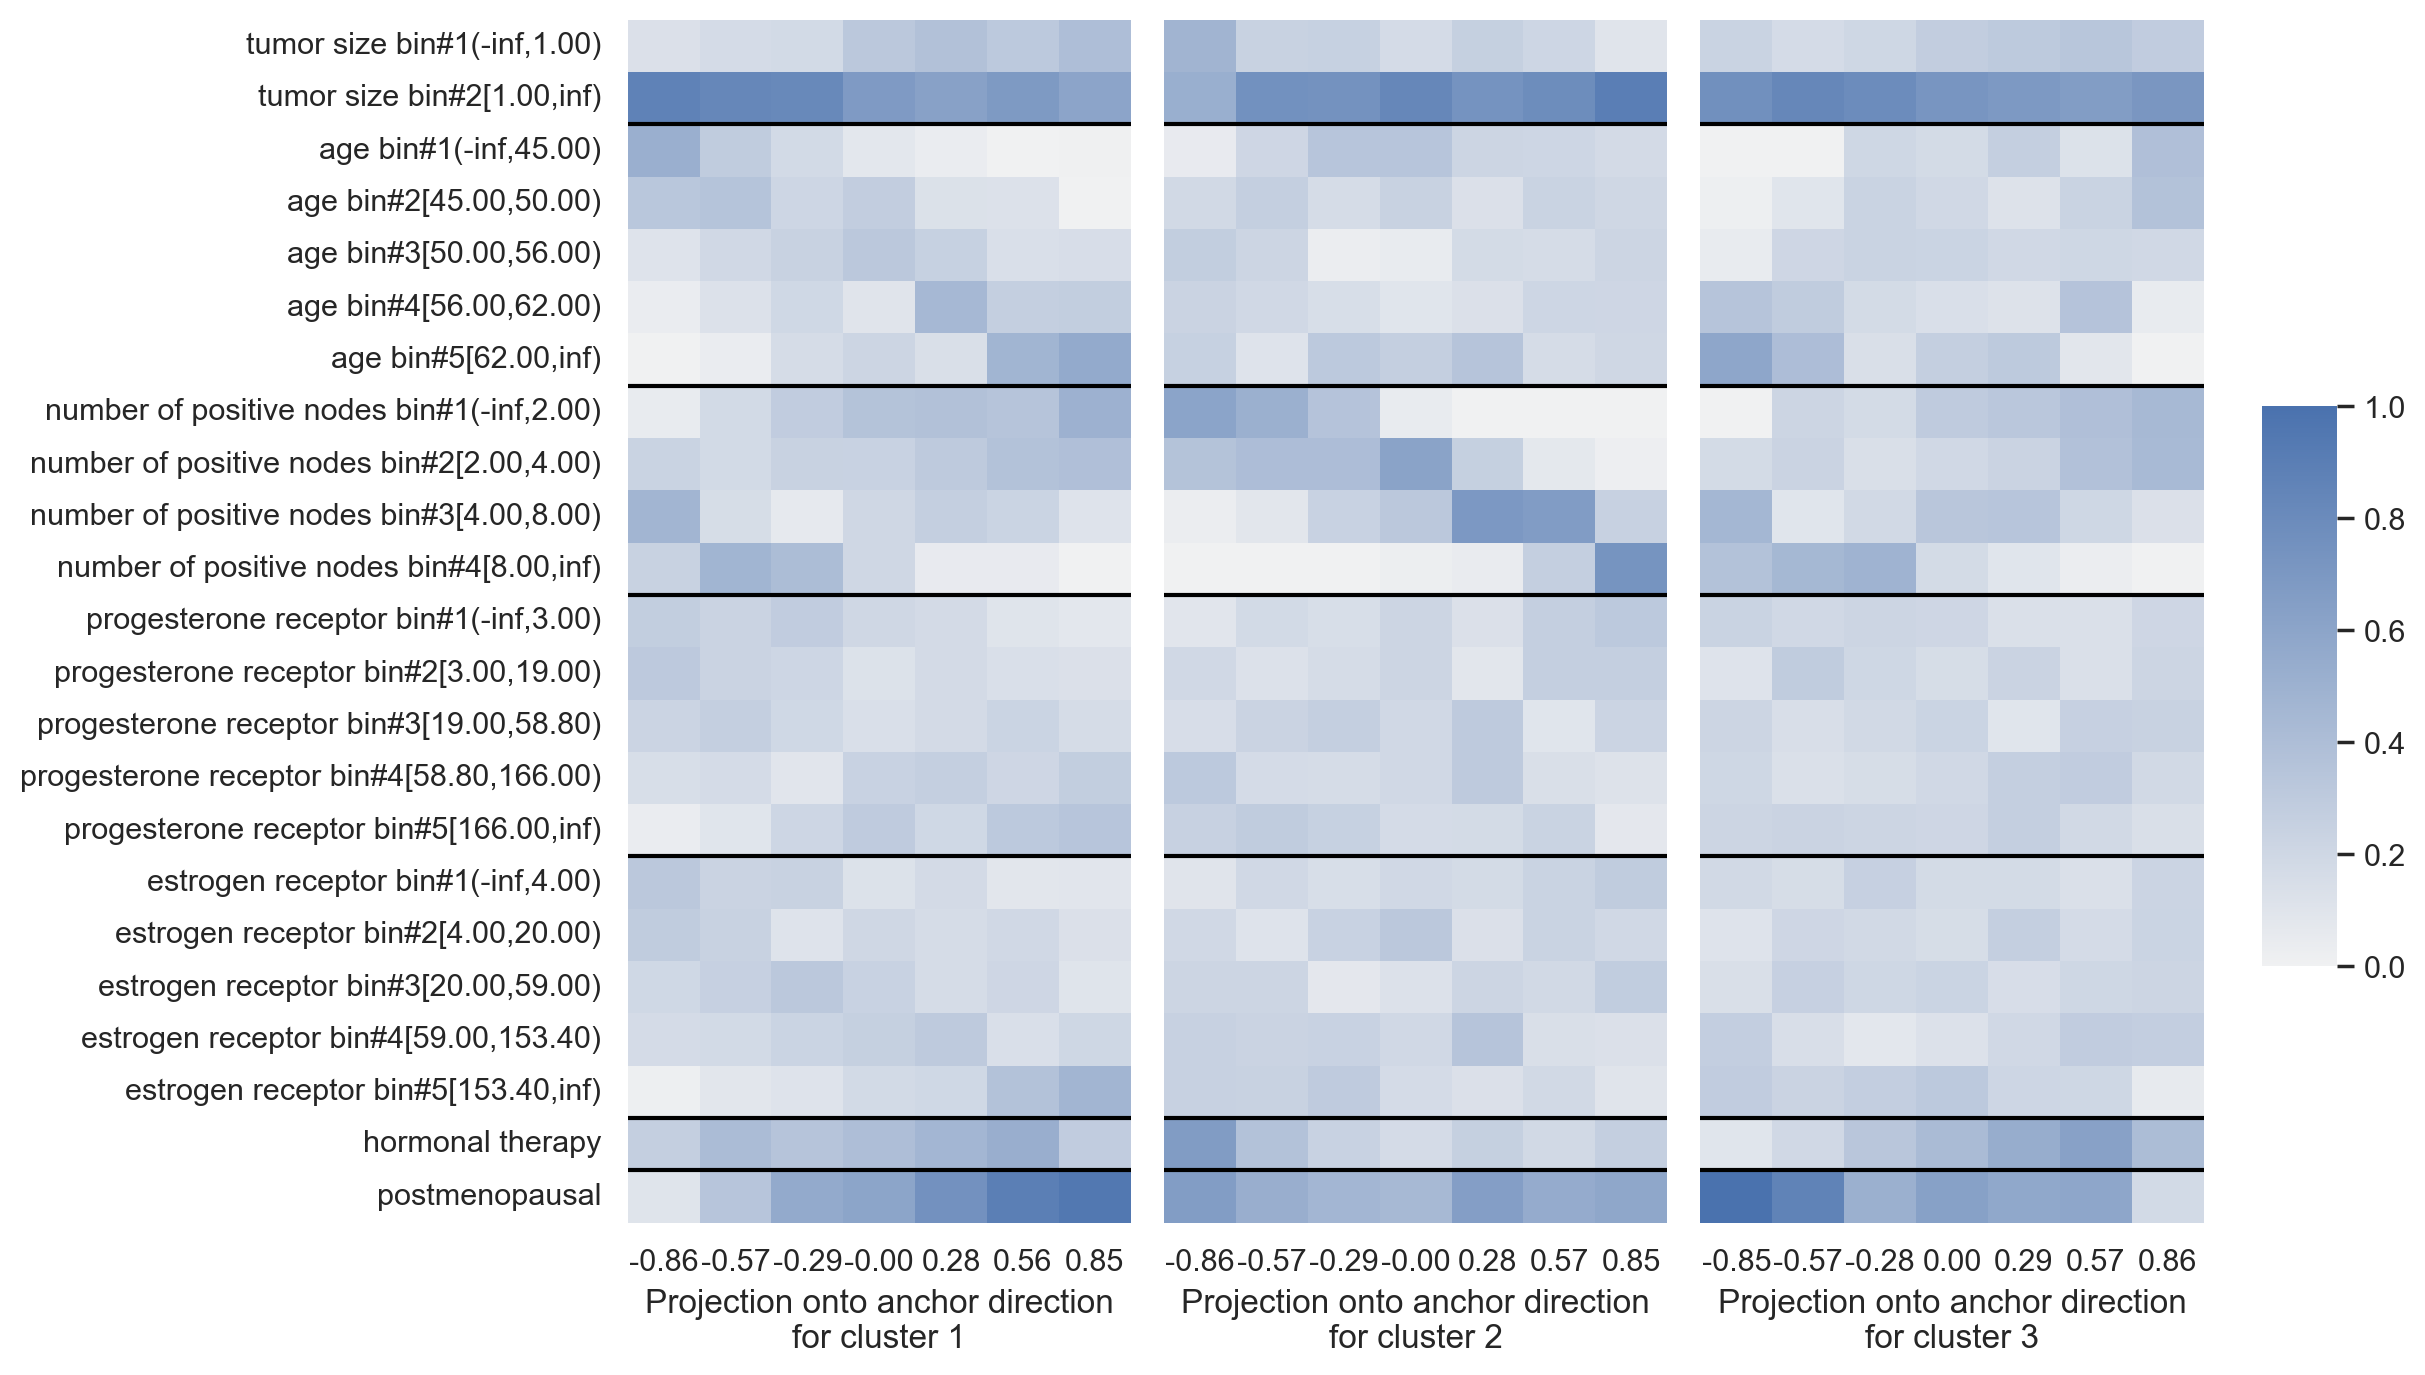

In [18]:
n_bins = 7
fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(12.5, 7))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for cluster_idx in range(final_n_clusters):
    ax = axn.flat[cluster_idx]
    current_row = 0
    for idx, count in enumerate(all_n_bins_to_use[:-1]):
        current_row += count
        ax.plot([0, n_bins], [current_row, current_row], 'black')
    sns.heatmap(pd.DataFrame(all_raw_feature_probability_heatmaps[cluster_idx],
                             index=discretized_feature_names,
                             columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                           + all_bin_edges[cluster_idx][1:])/2]),
                ax=ax,
                cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
                vmin=0, vmax=1,
                cbar=(cluster_idx == 0),
                cbar_ax=None if (cluster_idx != 0) else cbar_ax)
    ax.set_xlabel('Projection onto anchor direction\nfor cluster %d' % (cluster_idx + 1))
fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
plt.savefig('rotterdam-gbsg-raw-feature-prob-heatmaps-hypersphere.pdf', bbox_inches='tight')

Plot survival probability heatmaps (all in one big plot):

In [19]:
from scipy import interpolate

n_rows = 10
discrete_time_grid = np.linspace(unique_train_times.min(), unique_train_times.max(), n_rows)

all_survival_probability_heatmaps = []
for cluster_idx in range(final_n_clusters):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

    bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
    bin_edges_copy_with_inf_right_edge = bin_edges.copy()
    bin_edges_copy_with_inf_right_edge[-1] = np.inf

    bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

    heatmap = np.zeros((n_rows, n_bins))
    for projection_bin_idx in range(n_bins):
        projection_bin_surv = interpolate.interp1d(
            unique_train_times,
            predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
        heatmap[:, projection_bin_idx] = projection_bin_surv(discrete_time_grid)[::-1]

    all_survival_probability_heatmaps.append(heatmap)

/tmp/ipykernel_4001431/654045766.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


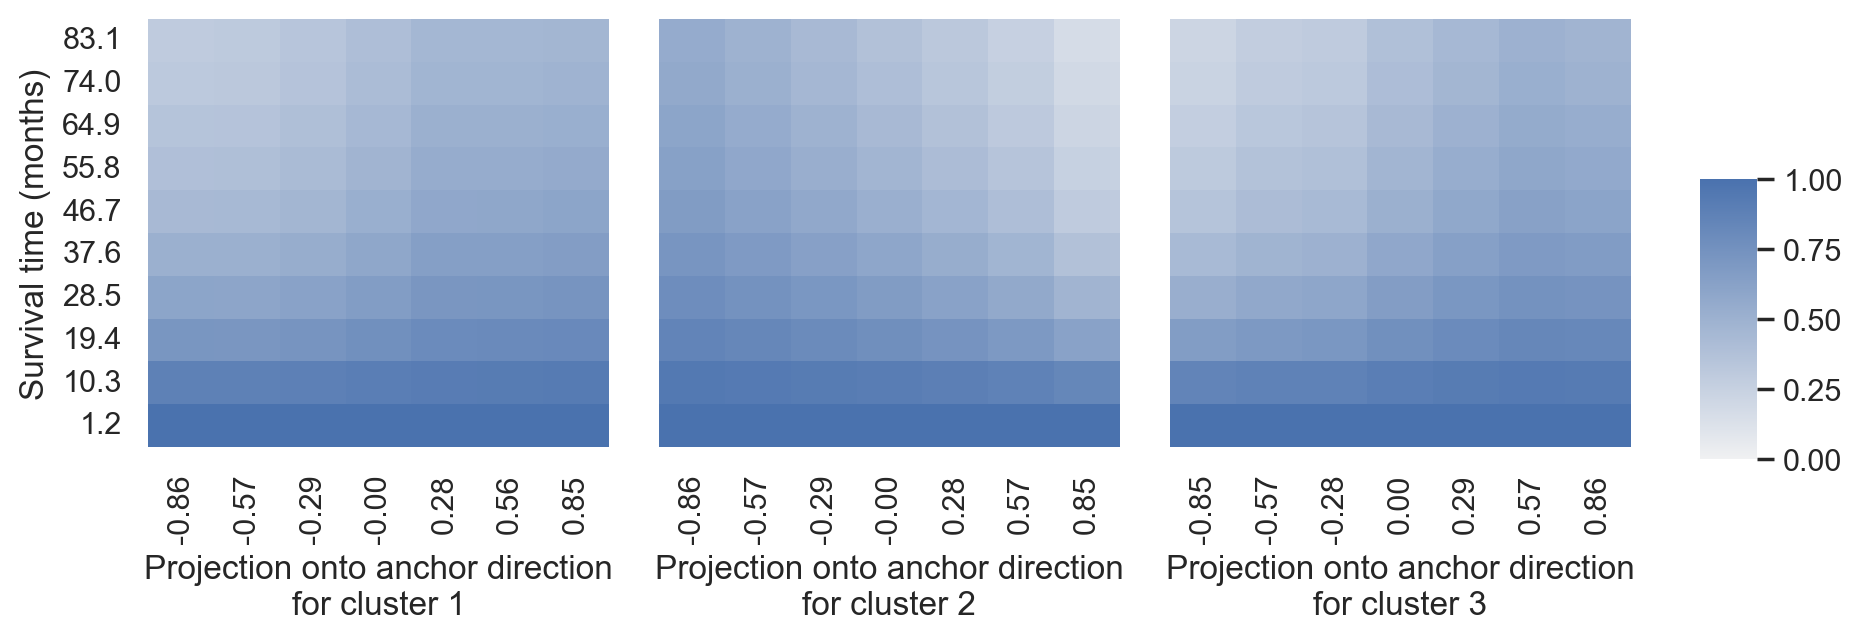

In [20]:
fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(9.5, 3.5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for cluster_idx in range(final_n_clusters):
    ax = axn.flat[cluster_idx]
    sns.heatmap(
        pd.DataFrame(all_survival_probability_heatmaps[cluster_idx],
                     index=['%.1f' % x for x in discrete_time_grid[::-1]],
                     columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                   + all_bin_edges[cluster_idx][1:])/2]),
        cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
        vmin=0, vmax=1, ax=ax,
        cbar=(cluster_idx == 0),
        cbar_ax=None if (cluster_idx != 0) else cbar_ax)
    ax.set_xlabel('Projection onto anchor direction\nfor cluster %d' % (cluster_idx + 1))
    if cluster_idx == 0:
        ax.set_ylabel('Survival time (months)')
fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)
plt.savefig('rotterdam-gbsg-surv-prob-heatmaps-hypersphere.pdf', bbox_inches='tight')

### Ranking anchor directions based on median survival time

In [21]:
alpha = .1

# estimate a survival curve for the top alpha fraction of visualization data points per cluster/anchor direction
anchor_direction_median_survival_time_pairs = []
for cluster_idx in range(final_n_clusters):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])
    q_alpha = np.sort(projections)[int(np.ceil((1-alpha)*len(projections)))]

    surv_curv_alpha = predicted_surv_vis[projections >= q_alpha].mean(axis=0)
    median_surv_time_estimate = compute_median_survival_times(surv_curv_alpha, unique_train_times)
    anchor_direction_median_survival_time_pairs.append((cluster_idx, median_surv_time_estimate))

# sort anchor directions by median survival time estimates
sorted_anchor_direction_median_survival_time_pairs = \
    sorted(anchor_direction_median_survival_time_pairs, key=lambda x: x[1])
for cluster_idx, median_survival_time in sorted_anchor_direction_median_survival_time_pairs:
    print('Cluster', cluster_idx + 1, ': median survival time estimate', median_survival_time)

Cluster 2 : median survival time estimate 25.2648868560791
Cluster 1 : median survival time estimate 70.96509552001953
Cluster 3 : median survival time estimate 76.68172454833984


### Feature interaction example

Here's an illustration of how to figure out possible feature interactions for each cluster's anchor direction. The basic idea: we train an "easy-to-interpret" regression model that maps from raw inputs to projection values for the anchor direction and where prediction allows for interactions. Here, we train a so-called *optimal regression tree* from the company Interpretable AI (requires a license). This method basically yields a single sparse tree where each leaf is determined by at most a few features (which are features that could have some interesting interaction). As we stated in our paper, we caution that these interactions should be interpreted with care (changing the max depth of the tree and using different random splits of the data for training and validation could potentially yield different trees and thus the interactions that get surfaced might not always be exactly the same).

In [22]:
from interpretableai import iai

columns = ['hormonal therapy',
           'tumor size',
           'postmenopausal',
           'age',
           'number of positive nodes',
           'progesterone receptor',
           'estrogen receptor',
           'projection value']

def get_decision_tree(cluster_idx):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])
    df = pd.DataFrame(np.hstack((raw_vis, projections.reshape(-1, 1))),
                      columns=columns)
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1]
    grid = iai.GridSearch(
        iai.OptimalTreeRegressor(
            random_seed=3943514174,
        ),
        max_depth=range(1, 4),
    )
    grid.fit_cv(X, y)
    learner = grid.get_learner()
    print(grid.get_learner())
    return learner

In [23]:
get_decision_tree(0)

Fitted OptimalTreeRegressor:
  1) Split: age < 52.5
    2) Split: number of positive nodes < 3.5
      3) Split: progesterone receptor < 76.5
        4) Predict: -0.5272, 80 points, error 0.1061
        5) Predict: 0.07242, 61 points, error 0.1777
      6) Split: progesterone receptor < 331
        7) Predict: -0.7719, 106 points, error 0.02453
        8) Predict: 0.03665, 12 points, error 0.2206
    9) Split: number of positive nodes < 5.5
      10) Split: age < 59.5
        11) Predict: 0.4099, 76 points, error 0.1689
        12) Predict: 0.7217, 108 points, error 0.04445
      13) Split: progesterone receptor < 64.5
        14) Predict: -0.3579, 52 points, error 0.06014
        15) Predict: 0.1715, 20 points, error 0.124


[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


Fitted OptimalTreeRegressor:
  1) Split: age < 52.5
    2) Split: number of positive nodes < 3.5
      3) Split: progesterone receptor < 76.5
        4) Predict: -0.5272, 80 points, error 0.1061
        5) Predict: 0.07242, 61 points, error 0.1777
      6) Split: progesterone receptor < 331
        7) Predict: -0.7719, 106 points, error 0.02453
        8) Predict: 0.03665, 12 points, error 0.2206
    9) Split: number of positive nodes < 5.5
      10) Split: age < 59.5
        11) Predict: 0.4099, 76 points, error 0.1689
        12) Predict: 0.7217, 108 points, error 0.04445
      13) Split: progesterone receptor < 64.5
        14) Predict: -0.3579, 52 points, error 0.06014
        15) Predict: 0.1715, 20 points, error 0.124

In [24]:
get_decision_tree(1)

Fitted OptimalTreeRegressor:
  1) Split: hormonal therapy < 0.5
    2) Split: number of positive nodes < 2.5
      3) Split: age < 57.5
        4) Predict: -0.619, 108 points, error 0.065
        5) Predict: -0.2739, 37 points, error 0.02469
      6) Split: number of positive nodes < 4.5
        7) Predict: 0.1309, 61 points, error 0.1735
        8) Predict: 0.8002, 120 points, error 0.04819
    9) Split: number of positive nodes < 5.5
      10) Split: number of positive nodes < 3.5
        11) Predict: -0.8126, 109 points, error 0.02352
        12) Predict: -0.4389, 23 points, error 0.0602
      13) Split: number of positive nodes < 8.5
        14) Predict: 0.28, 20 points, error 0.1318
        15) Predict: 0.8803, 37 points, error 0.02554


Fitted OptimalTreeRegressor:
  1) Split: hormonal therapy < 0.5
    2) Split: number of positive nodes < 2.5
      3) Split: age < 57.5
        4) Predict: -0.619, 108 points, error 0.065
        5) Predict: -0.2739, 37 points, error 0.02469
      6) Split: number of positive nodes < 4.5
        7) Predict: 0.1309, 61 points, error 0.1735
        8) Predict: 0.8002, 120 points, error 0.04819
    9) Split: number of positive nodes < 5.5
      10) Split: number of positive nodes < 3.5
        11) Predict: -0.8126, 109 points, error 0.02352
        12) Predict: -0.4389, 23 points, error 0.0602
      13) Split: number of positive nodes < 8.5
        14) Predict: 0.28, 20 points, error 0.1318
        15) Predict: 0.8803, 37 points, error 0.02554

In [25]:
get_decision_tree(2)

Fitted OptimalTreeRegressor:
  1) Split: hormonal therapy < 0.5
    2) Split: age < 52.5
      3) Split: number of positive nodes < 4.5
        4) Predict: 0.6931, 123 points, error 0.1092
        5) Predict: -0.1673, 70 points, error 0.08528
      6) Split: number of positive nodes < 2.5
        7) Predict: -0.3488, 59 points, error 0.0854
        8) Predict: -0.7921, 74 points, error 0.01721
    9) Split: age < 59.5
      10) Split: number of positive nodes < 7.5
        11) Predict: 0.759, 88 points, error 0.0626
        12) Predict: -0.1465, 25 points, error 0.09479
      13) Split: number of positive nodes < 6.5
        14) Predict: 0.1791, 57 points, error 0.07536
        15) Predict: -0.6232, 19 points, error 0.03435


Fitted OptimalTreeRegressor:
  1) Split: hormonal therapy < 0.5
    2) Split: age < 52.5
      3) Split: number of positive nodes < 4.5
        4) Predict: 0.6931, 123 points, error 0.1092
        5) Predict: -0.1673, 70 points, error 0.08528
      6) Split: number of positive nodes < 2.5
        7) Predict: -0.3488, 59 points, error 0.0854
        8) Predict: -0.7921, 74 points, error 0.01721
    9) Split: age < 59.5
      10) Split: number of positive nodes < 7.5
        11) Predict: 0.759, 88 points, error 0.0626
        12) Predict: -0.1465, 25 points, error 0.09479
      13) Split: number of positive nodes < 6.5
        14) Predict: 0.1791, 57 points, error 0.07536
        15) Predict: -0.6232, 19 points, error 0.03435